# Homework 7 - Monte Carlo and Fast Exponential Transform

## Problem 0 (45 points) - Metroplis-Hastings algorithm

Suppose we have 10 particles with positions $x_i$  resting in potential well $V(x)= x^4-x^2-0.1x$:

/Users/shiqianxu/miniconda3/envs/pycourse/bin/python


Text(0, 0.5, 'V(x)')

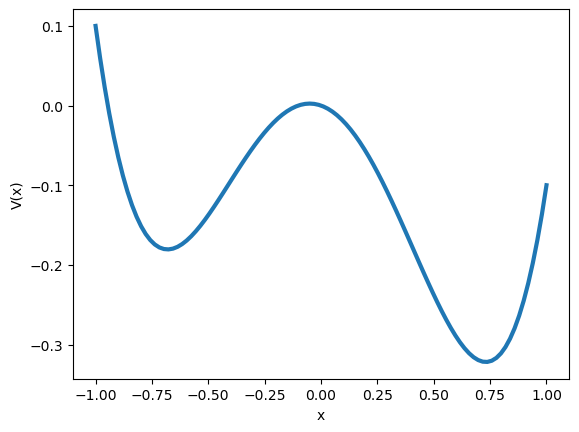

In [1]:
import sys
print(sys.executable)


import numpy as np
import matplotlib.pyplot as plt

V = lambda x: x**4 - x**2 - 0.1*x # confining potential
#p = lambda x: np.exp(-V(x))
xx = np.linspace(-1, 1, 100)
plt.plot(xx, V(xx), linewidth=3)
plt.xlabel('x')
plt.ylabel('V(x)')

If the particles have charges $q_i$, then the total energy of the system is
$$
H(\boldsymbol{x}) = \sum_{\text{pairs} (i,j)} \frac{q_iq_j}{|x_i-x_j|} + \sum_i V(x_i).
$$
According to satistical physics, if the particles are in thermal equillibrium at temperature $T$, then probability distribution of particles will be
$$
p(\boldsymbol{x}) = Z^{-1} e^{-H(\boldsymbol{x})/T},
$$
where $Z$ is a normalizing constant.


We will use the Metroplis-Hastings algorithm to find the expected number of particles in the right well ($x>0$).

The following function will generate our initial condition.

In [2]:
def gen_pts(npart=10):
    ' Generate n charged particles with random positions and charges '
    xs = 2*np.random.rand(npart) - 1# uniformly distributed intial condition
    qs = np.random.rand(npart)
    return xs, qs

### Part A (5 points)
In the Metroplis-Hastings algorithm, we propose a new sample based on the previous sample:
$$
\boldsymbol{y}_{k+1} = F_i(\boldsymbol{x}_{k})
$$
For this problem, we shall need three kinds of steps one for moving our particles. In the first kind of step, which we call `walk_step`, will move the particles slightly:
$$
y_{i,k+1} = x_{i,k} + \delta W_{i,k},
$$
where $W_{i,k}$ is a standard normal random variable.
In the second kind of step (`swap_step`), we will randomly permute the particles:
$$
y_{i,k+1} = x_{P(i),k},
$$
where $P$ is a random parmutation.
The final kind of step (`flip_step`) will move one random particle ($j_k$) to the other well.
$$ 
y_{i,k+1} = \begin{cases} -x_{i,k} & i == j_{k}\\ x_{i,k} &\text{o.w.}\end{cases}
$$

The overall rule for generating the $y_{i,k+1}$ will be to do a `swap_step` with probability $a$, a `flip_step` with probability $b$, or `walk_step` if we do neither of the other steps.

Once we have generated the proposed step $\boldsymbol{y}_{k+1}$, the Metroplis-Hastings algorithm says that we accept it (i.e. set $\boldsymbol{x}_{k+1}=\boldsymbol{y}_{k+1}$) with probability $\min(p(\boldsymbol{y}_{k+1})/p(\boldsymbol{x}_{k}),1)$. If the step is rejectect, we set $\boldsymbol{x}_{k+1}=\boldsymbol{x}_{k}$.

Fill in the functions below to allow us to generate the next sample in the Metrpolis-Hastings alogirthm.

In [3]:
import numpy as np

def walk_step(xs, delta=0.1):
    return xs + np.random.randn(len(xs)) * float(delta)

def swap_step(xs):
    x_new = xs.copy()
    n = len(xs)
    i, j = np.random.choice(n, 2, replace=False)
    x_new[i], x_new[j] = float(x_new[j]), float(x_new[i])
    return x_new

def flip_step(xs):
    n = len(xs)
    i = np.random.choice(n)
    x_new = xs.copy()
    x_new[i] = -1.0 * x_new[i]  # Assuming the "other well" is the negative of the current position
    return x_new

def mc_step(xs, p, a, b):
    n = len(xs)
    u = np.random.rand()
    
    if u < a:
        xs_p = walk_step(xs)
    elif u < a + b:
        xs_p = flip_step(xs)
    else:
        xs_p = swap_step(xs)
    
    res = []
    for i in range(len(xs)):
        calc = float(np.exp(-(float(xs_p[i])**4 - xs_p[i]**2 - 0.1*xs_p[i])) / np.exp(-(float(xs[i])**4 - xs[i]**2 - 0.1*xs[i])))
        acceptance_prob = min(1, calc)
        if np.random.rand() < acceptance_prob:
            res.append(xs_p[i]) # Accept the new step
        else:
            res.append(xs[i]) # Reject the new step and keep the old positions
    return res

### Part B (15 points) - Note the weight of this question
A Monte Carlo scheme will only converge quickly if the generated samples rapidly explore the state space (i.e. the potential particle positions).

Technically `walk_step` is capable of reordering the particles and moving particles to the other well and therefore exploring the state space.
Why will introducing `swap_step` and `flip_step` allow our scheme to converge faster? 

# Part C (10 points)
Complete the function `mcmc_sim`, which generates the samples $\boldsymbol{x}_{1},\;\boldsymbol{x}_{2},\;\ldots$. You will need to initialize the system with `gen_part` and then run `nburn` steps to allow the system to converge to it's equillibrium distribution. After that initialization period, generate `nsamp` new samples and save them. The function should then return those saved samples.

Once the function is completed, use it with `nsamp = 10**4` and `nburn = 10**2` to estimate the number of particles in the right well.

In [4]:
def mcmc_sim(nsamp, nburn, npart=10, T=2, a = 0.2, b = 0.4):
    # Initialize the system
    xs, _ = gen_pts(npart)

    # Burn-in period: allow the system to reach equilibrium
    for _ in range(nburn):
        xs = mc_step(xs, p, a, b)

    # Generate and save samples after the system has equilibrated
    samples = []
    for _ in range(nsamp):
        xs = mc_step(xs, p, a, b)
        samples.append(xs.copy())  # Save the sample

    return samples

# Example of running the simulation, assuming nsamp = 10**4 and nburn = 10**2 as per your instructions
nsamp = 10**4
nburn = 10**2

samples = mcmc_sim(nsamp, nburn)

# Now, we can estimate the number of particles in the right well (x > 0)
pts = sum(1 for sample in samples for x in sample if x > 0)
estimate = pts / nsamp
print(f'Estimated number of particles in the right well: {estimate}')


Estimated number of particles in the right well: 5.6383


### Part D (5 points)
Make a histogram of the particle positions using the same samples as in the previous question. Note that for this problem, we don't distinguish between particles $i$ and $j$, so you should "flatten" the samples into a one-dimensional array  before plotting.

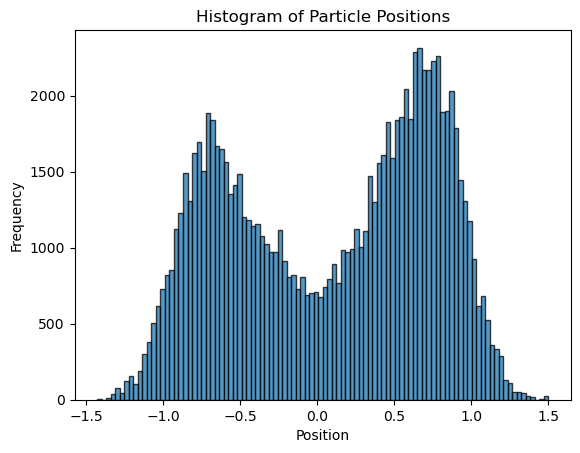

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# Flatten the list of arrays into a one-dimensional array
flat = np.concatenate(samples)

# Create the histogram of the particle positions
plt.hist(flat, bins=100, alpha=0.75, edgecolor='black')

plt.title('Histogram of Particle Positions')
plt.xlabel('Position')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

### Part E (10 points)
For this problem set `nsamp = 10**3`. Compare the estimate with `nburn = 0` and `nburn = 10**3`. Which one is closer to your estimate from the previous question and why?

In [6]:
# Run the simulation with no burn-in steps
nsamp = 10**3
nburn = 0

sam_no_burn = mcmc_sim(nsamp, nburn)
pts = sum(1 for sample in sam_no_burn for x in sample if x > 0)
no_burn = pts / (nsamp * 10)

# Run the simulation with a large number of burn-in steps
nburn_large = 10**3
sam_large = mcmc_sim(nsamp, nburn_large)
pts_large = sum(1 for sample in sam_large for x in sample if x > 0)
large_burn = pts_large / (nsamp * 10)

no_burn, large_burn

(0.471, 0.61)

## Problem 1 (30 points) - Fast Exponential Transform

In this problem, we will experiment with a common fast algorithm for applying exponential functions in 1D. Suppose we have sorted points $x_0,\dots,x_{n-1} \in \mathbb{R}$ and "weights" $c_0,\dots,c_{n-1}$ and we want to compute the sum
$$f_i = \sum_{j=0}^{n-1} \exp(-|x_i-x_j|) c_j,$$
for $i=0,1,2,\dots,n-1.$ 

### Part A (5 points)

The most straightforward way to find $f_0,\dots,f_{n-1}$ is via linear algebra. Make a big matrix $E$ with $E_{i,j}= \exp(-|x_i-x_j|).$ If we set $c$ to be the vector of weights, and $f$ to be the vector of values we want, then we get
$$f = Ec.$$

Implement a routine `exp_transform(x,c)` which takes in a vector of $x$ "positions" ($x_0<x_1<\dots<x_{n-1}$) and a vector of weights $c$ and outputs the corresponding $f$ values as a vector using this approach.

Test its performance in terms of time by taking 200,400,800,1600,3200,6400,10000 random normal numbers for the $x$ positions and setting all of the $c$'s to be one (only time the `exp_transform(x,c)` routine, not the time to generate $x$ or sort it). Plot your results. If the latter trials are taking too long then feel free to exclude them from your results (just make a note).

In [7]:
import numpy as np
import time
def exp_transform(x, c):
    n = len(x)
    E = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            E[i, j] = np.exp(-np.abs(x[i] - x[j]))
    f = E.dot(c)
    return f

# Testing the performance
# Since we don't actually have the random normal numbers, we'll simulate them for the test
for size in [200, 400, 800, 1600, 3200, 6400, 10000]:
    x = np.sort(np.random.randn(size))
    c = np.random.randn(size)
    
    # Measure the time taken to compute the transformation
    start_time = time.time()
    f_values = exp_transform(x, c)
    end_time = time.time()
    
    print(f"Size: {size}, Time taken: {end_time - start_time} seconds")
    

Size: 200, Time taken: 0.06305813789367676 seconds
Size: 400, Time taken: 0.38582777976989746 seconds
Size: 800, Time taken: 0.9740447998046875 seconds
Size: 1600, Time taken: 3.6068637371063232 seconds
Size: 3200, Time taken: 14.475741147994995 seconds
Size: 6400, Time taken: 57.985138177871704 seconds
Size: 10000, Time taken: 140.55831384658813 seconds


Unfortunately, for large $n,$ (think 10's of thousands to millions) creating and storing $E$ can get expensive, and applying the matrix will take $O(n^2)$ operations. Let's try to find a better way. For a given point $x_i$ let $L_i$ be the collection of all the points to the left of $x_i$ and $R_i$ be the collection of all points to the right of $x_i.$ Then

$$ f_i = c_i + \sum_{j \in L_i} \exp(x_j-x_i) c_j +\sum_{j \in R_i} \exp(x_i-x_j) c_j.$$

Set $w_i = \sum_{j \in L_i} \exp(x_j-x_i) c_j,$ and $u_i = \sum_{j \in R_i} \exp(x_i-x_j) c_j.$ Then, after some arithmetic, we see that
$$w_{i+1} = \exp(x_i-x_{i+1}) (w_i + c_i)$$
and
$$u_{i-1} = \exp(x_{i-1}-x_{i}) (u_i + c_i)$$

### Part B (10 points)

Write a function, `sweep_right(x,c)` which computes all the $w$'s using the above recurrence formula. Your routine should start with $w_0 = 0,$ and compute $w_1 = \exp(x_0-x_1)*c_0,$ then $w_2 = \exp(x_1-x_2)*(w_1+c_1),$ and so on.

Write a function, `sweep_left(x,c)` which computes all the $u$'s using the above recurrence formula. Your routine should start with $u_{n-1} = 0,$ and compute $u_{n-2} = \exp(x_{n-2}-x_{n-1})*c_{n-1},$ then $u_{n-3} = \exp(x_{n-3}-x_{n-2})*(u_{n-2}+c_{n-2}),$ and so on. When implementing this method, it might be helpful to use `numpy.flip` to reverse the $x$ and $c$ vectors to make your code look similar to `sweep_right` - just make sure to check the signs in the exponents and to make sure that the output is flipped properly.

In [8]:
import numpy as np

def sweep_right(x, c):
    n = len(x)
    w = np.zeros(n)
    w[0] = 0
    w[1] = np.exp(x[0] - x[1]) * c[0]
    for i in range(2, n):
        w[i] = np.exp(x[i-1] - x[i]) * (w[i-1] + c[i-1])
    return w

def sweep_left(x, c):
    n = len(x)
    u = np.zeros(n)
    u[-1] = 0
    for i in range(n - 2, -1, -1):
        u[i] = np.exp(x[i] - x[i+1]) * c[i+1]
    return u

### Part C (10 points)

Write a function `fast_exp_transform(x,c)` which takes in a vector of $x$ "positions" ($x_0<x_1<\dots<x_{n-1}$) and a vector of weights $c$ and outputs the corresponding $f$ values as a vector using your `sweep_left` and `sweep_right` functions and the formula above.

Test its accuracy against `exp_transform` for a small number of points (100 let's say).

Test its performance in terms of time by taking 200,400,800,1600,3200,6400,10000 random normal numbers for the $x$ positions and setting all of the $c$'s to be one (only time the `fast_exp_transform(x,c)` routine, not the time to generate $x$ or sort it). Plot your results. *Make sure the points are sorted!* 

How many points can you do? 

What is the crossover point between this approach and `exp_transform` if any? i.e. for what value of $n$ will the two take about the same time?

What is the computational complexity (in $n$) of your `fast_exp_transform` code?

Size 200:
[-1.1823425290879, -0.6632681364198508, -2.716474515412765, 17.604144995465095, 2.065844032646853, 1.3371142735391002, 1.074207054110549, 1.0287899797392774, 0.7648809374750694, 0.7069009666708331, 1.4000778215616043, 1.2578235814799579, 1.0694776640342816, 1.8489039428033058, 1.2828919491489577, 0.7577214231374659, 0.6743424027195325, 1.003892026581454, 1.5097602841962374, -1.9319302148142536, -1.050204686401156, -1.4882829334424275, -0.6329780414814979, -0.5386359992479355, -0.5715536996291444, -0.6917726292256081, -0.6248124382326025, -0.7909820736776181, -1.187003663288051, -0.7731257505148481, -1.1892841932483882, -1.683831010863243, -1.0756927325602392, -0.982055839360326, -0.7465055031048644, -0.7298184770946411, -0.6235563293086468, -0.6535682344344974, -0.7562045990968956, -0.8156385780304558, -0.9253054276733035, -1.249867321102573, -0.9634039756662545, -1.4514421433860685, -1.535840564185709, -1.873506465839378, -2.918751017064153, -2.7861429649648786, -2.854204118

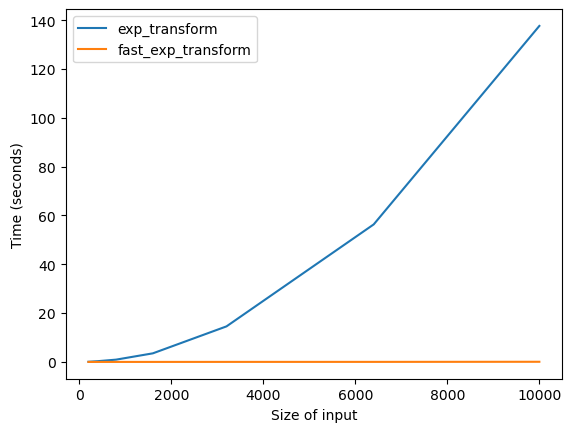

In [9]:
import numpy as np
import time

def fast_exp_transform(x, c):
    u_left = sweep_left(x, c)
    u_right = sweep_right(x, c)
    return u_left + u_right + c

# Now we'll test the accuracy and performance of both exp_transform and fast_exp_transform
sizes = [200, 400, 800, 1600, 3200, 6400, 10000]
exp_times = []
fast_times = []
percents = []
for size in sizes:
    x = np.sort(np.random.randn(size))
    c = np.random.randn(size)
    # Testing exp_transform
    start_time = time.time()
    f_exp = exp_transform(x, c)
    exp_times.append(time.time() - start_time)

    # Testing fast_exp_transform
    start_time = time.time()
    f_fast = fast_exp_transform(x, c)
    fast_times.append(time.time() - start_time)

    if size < 400:
        percent = [f_exp[i] / float(f_fast[i]) for i in range(len(f_exp))]
        percents.append((size, percent))

# print the percentage of smaller size to see the accuracy
for i in percents:
    print(f"Size {i[0]}:")
    print(i[1])
    print()

# Plot the results
plt.plot(sizes, exp_times, label='exp_transform')
plt.plot(sizes, fast_times, label='fast_exp_transform')
plt.xlabel('Size of input')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()



### Part D (5 points)

Try to optimize both codes as much as possible. For example, you could try to vectorize the construction of the exponentials in the first approach. You could try to use `numba` to try to accelerate the second. You can precompute the exponentials of the distances between consecutive $x$ values and pass that as an optional argument to your sweeping routines. How much can you improve your code? This is an open-ended question and there is no "right" answer. 

In [10]:
#!pip install numba

from numba import njit

@njit
def sweep_right(x, c):
    n = len(x)
    w = np.zeros(n)
    w[0] = 0
    w[1] = np.exp(x[0] - x[1]) * c[0]
    for i in range(2, n):
        w[i] = np.exp(x[i-1] - x[i]) * (w[i-1] + c[i-1])
    return w

@njit
def sweep_left(x, c):
    n = len(x)
    u = np.zeros(n)
    u[-1] = 0
    for i in range(n - 2, -1, -1):
        u[i] = np.exp(x[i] - x[i+1]) * c[i+1]
    return u

# You would also JIT compile the fast_exp_transform function
@njit
def fast_exp_transform(x, c):
    u_left = sweep_left(x, c)
    u_right = sweep_right(x, c)
    return u_left + u_right + c



def exp_transform_vectorized(x, c):
    x_diff = np.abs(x[:, None] - x)  # Compute the differences in a vectorized manner
    E = np.exp(-x_diff)             # Compute the exponential matrix
    f = E @ c                       # Matrix-vector multiplication
    return f

# You can use Numba here as well for JIT compilation
@njit
def exp_transform_vectorized(x, c):
    x_diff = np.abs(x[:, None] - x)
    E = np.exp(-x_diff)
    f = E @ c
    return f

